# Определение возраста покупателей. Описание проекта.
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:


- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;


- Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. Добейтесь значения MAE на тестовой выборке не больше 8.

# Исследовательский анализ данных

### Загрузка и иследование данных.

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.sample(5)

,file_name,real_age
428,000428.jpg,21
3069,003069.jpg,20
466,000466.jpg,20
6068,006071.jpg,34
1820,001820.jpg,16


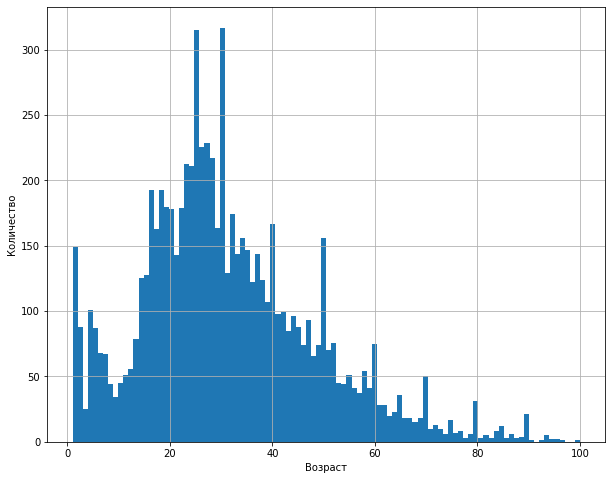

In [ ]:
plt.figure(figsize=(10, 8))
labels['real_age'].hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show();

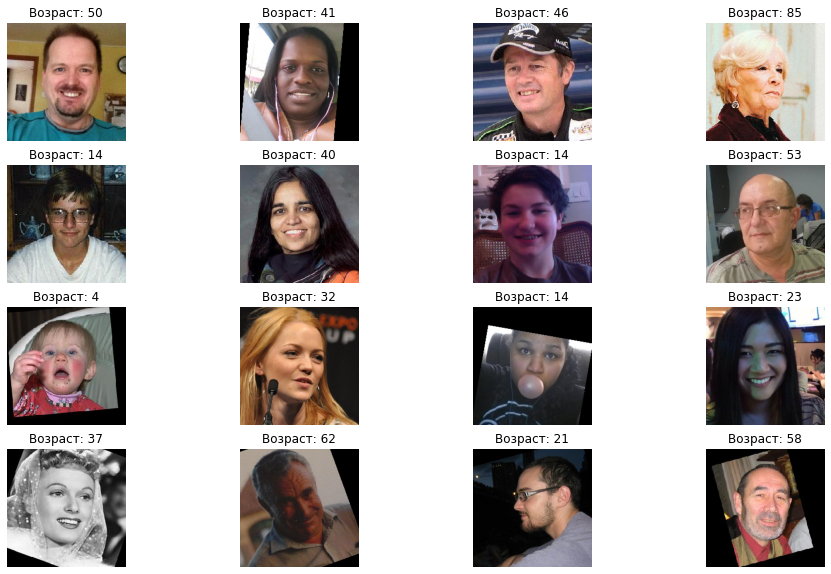

In [ ]:
features, target = next(train_gen_flow)

fig, axes = plt.subplots(4, 4, figsize=(16, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(features[i])
    ax.set_title(f"Возраст: {target[i]}")
    ax.axis('off')

plt.show()

### Выводы.

- Необходимые для работы библиотеки и данные загружены.

- Пропусков в датасете нет.

- Как видно из гистаграммы, больше всего в датасете представлено людей в возрасте 20-40 лет, меньше всего - в возрасте 80-100 лет.

- Фотографии людей имеют совершенно разное качество: есть как цветные, так и чёрно-белые, все фото имеют разный фон, часть развёрнуты.

# Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1/255
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=1
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=1
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data,
    batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model
```

```
# результат вывода на экран сюда
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-06-11 11:11:00.750129: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-11 11:11:01.396261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 79s - loss: 167.1201 - mae: 9.9085 - val_loss: 596.4529 - val_mae: 19.2602
Epoch 2/10
356/356 - 60s - loss: 79.7814 - mae: 6.8284 - val_loss: 155.5771 - val_mae: 9.7107
Epoch 3/10
356/356 - 60s - loss: 55.7749 - mae: 5.7145 - val_loss: 90.1299 - val_mae: 7.3676
Epoch 4/10
356/356 - 62s - loss: 45.8740 - mae: 5.1738 - val_loss: 89.6813 - val_mae: 7.1885
Epoch 5/10
356/356 - 64s - loss: 39.7080 - mae: 4.8843 - val_loss: 91.7924 - val_mae: 7.2831
Epoch 6/10
356/356 - 63s - loss: 34.7783 - mae: 4.5534 - val_loss: 83.3987 - val_mae: 6.9551
Epoch 7/10
356/356 - 60s - loss: 32.3055 - mae: 4.4184 - val_loss: 96.8533 - val_mae: 7.7278
Epoch 8/10
356/356 - 61s - loss: 29.2373 - mae: 4.1605 - val_loss: 78.7393 - val_mae: 6.7749
Epoch 9/10
356/356 - 60s - loss: 30.2281 - mae: 4.2299 - val_loss: 82.4927 - val_mae: 7.0686
Epoch 10/10
356/356 - 61s - loss: 27.1127 - mae: 4.0404 - val_loss: 79.2660 - val_mae: 6.7768
```

# Анализ обученной модели

Итоги обучения модели:


- Предобученная модель ResNet в нашем случае работает достаточно быстро.

- Первоначально я пробовал запустить её с параметром learning_rate равным 0.001 и пятью эпохами, итоговое значение MAE оказалось выше порогового (около 10). Увеличение количества эпох до десяти и снижение в 10 раз значение learning_rate решило проблему.

- В итоге достигнуто значение MAE ниже порогового (6.7768).

#Итоговые выводы.


Было заявлено две бизнес-задачи, решение которых мы пытаемся достичь с помощью компьютерного зрения:


- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Итоговое значение MAE модели 6.7768. Прогнозируем мы возраст человека по фото в годах, значит, и ошибка измеряется также в годах. Количество лет не принято представлять в виде десятичных дробей с таким количечством знаков после запятой, поэтому для удобства понимания результата скажем, что модель, определяя возраст человека на фото, в среднем ошибается примерно на 7 лет.

В первой задаче было сказано, что система предложений товаров будет рассчитываться для возрастных групп, а не людей конкретных возрастов, что логично. Из этого могу сделать вывод, что с определённым допущением, но эту задачу можно считать решённой. Даже с погрешностью в 7 лет, если не считать детей и подростков, регистриуемые люди будут распределяться по возрастным группам более-менее верно.

Для решения же второй задачи нужно гораздо более точное определение возраста. Продажа алкоголя осуществляется строго с восемнадцатилетнего возраста, поэтому, если мы хотим точно контролировать работу кассиров в данном вопросе, есть необходимость в доработке модели с целью ощутимого снижения средней абсолютной ошибки.